# Using GloVe for text classification

In this pre-filled notebook, we use GloVe embeddings to train a classifier for sentiment analysis. For every review in the IMDB dataset we:
1. Tokenize the review into tokens.
2. Get the pre-trained GloVe vector for every token in the review (if they are in the voabulary of GloVe).
3. Average the vectors over the full review.
4. Send the vector through a logistic regression.

This time, we will batch the inputs instead of updating the weights once per epoch.

Before starting, to make your experiments reproducible, make sure to [force the random seed](https://pytorch.org/docs/stable/notes/randomness.html).

In [1]:
from copy import deepcopy
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

/home/aeschylli/scia/nlp/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Using GloVe (1 point)

Let's get familier with GloVe embeddings. We download a small version of GloVe trained of 6 billion words, and use vectors of size 300.

The [torchtext documentation](https://pytorch.org/text/stable/vocab.html#glove) being quite poor, you can find details on the different pre-trained vectors on the [Stanford page](https://nlp.stanford.edu/projects/glove/).

In [2]:
glove = GloVe(name="6B", dim=300)
len(glove.stoi)

400000

In [3]:
glove.stoi["cat"], glove.itos[5450], glove.vectors[glove.stoi["cat"]].shape

(5450, 'cat', torch.Size([300]))

In [4]:
glove.itos[:5]

['the', ',', '.', 'of', 'to']

Notice that punctuations are part of GloVe's vocabulary.

To compare two words, we can look at their cosine similarity.

In [5]:
words = ["cat", "cats", "dog", "fridge"]
for word in words[1:]:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[words[0]]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()  # .item() is used to turn a tensor of a single value to a float
    print(f"{words[0]} x {word} = {similarity}")

cat x cats = 0.6815836429595947
cat x dog = 0.6816746592521667
cat x fridge = 0.09630905091762543


**\[1 point\] Find the closest word to "cat" in the whole vocabulary.**

In [6]:
words = []
simi = []
for word in glove.itos:
  similarity = torch.cosine_similarity(glove.vectors[glove.stoi["cat"]].reshape(1, -1), glove.vectors[glove.stoi[word]].reshape(1, -1),).item()
  words.append(word)
  simi.append(similarity)
df = pd.DataFrame({"word": words, "simi": simi})
df.sort_values(by="simi", ascending=False, inplace=True)
df.head()


,word,simi
5450,cat,1.000000
2926,dog,0.681675
7760,cats,0.681584
6658,pet,0.587036
3876,dogs,0.540767


#### The closest word is **dog**

We have ordered the array of similarity so we can access the n closest word

## Dataset and split

As we keep the test set for final evaluation, we need to split the training set into a training and validation set. We make sure the split is **stratified** by class (same proportion of class in each split).

In [7]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/home/aeschylli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 30.89it/s]
Loading cached split indices for dataset at /home/aeschylli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /home/aeschylli/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

## Prepare the inputs

### Text processing pipeline (2 points)

For a given entry, we want to
1. Tokenize the text.
2. Get the vectors for each token.
3. Average them.

For tokenization, let's use the "basic_english" tokenizer from torchtext.

In [8]:
data = pd.DataFrame(train_df)

In [9]:
tokenizer = get_tokenizer("basic_english", language="en")
data = pd.DataFrame(train_df)
data

,text,label
0,After reading tons of good reviews about this ...,1
1,To be fair they did as well as they could with...,0
2,Really an amazing pile of pap! <br /><br />A p...,0
3,I saw this film last night following a lot of ...,0
4,One of the greatest film I have seen this year...,1
...,...,...
19995,"New York, I Love You is a collective work of e...",1
19996,The movie remains in the gray for far too long...,0
19997,SPOILERS THROUGH: <br /><br />I really am in t...,1
19998,Lets make a movie about a talk show that alrea...,0


**\[2 points\] Fill the `preprocess_text` function so it returns the mean of the GloVe vectors of all the tokens within a review.**

The two following functions can help.
* [torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html)
* [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html)

In [10]:
import functools
def vectorize_text(
    text: str, vocabulary: vocab.Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Turn a string into the average of the vectors of its tokens.
    Args:
        text: the input text.
        vocabulary: a pre-trained Vocab object.
        tokenizer: a tokenizer taking a text as input and returning a list of tokens.
    Returns:
        The average tensor over the tokens of the whole text.
    """
    
    data = tokenizer(text)
    res = []
    for word in data:
        try:
            res.append(glove.vectors[glove.stoi[word]])
        except KeyError:
            continue
    return sum(res) / len(res)

In [11]:
text_pipeline = partial(vectorize_text, vocabulary=glove, tokenizer=tokenizer)
assert text_pipeline("some text.").shape == torch.Size([300])

Now we turn our 3 sets into vectors and labels.

Our data are quite small, so we can keep everything in RAM.

In [12]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

100%|██████████| 25000/25000 [00:51<00:00, 486.40it/s]


### Batch processing (1 point)

Instead of doing one update per epoch, we feed the model batches of texts between each update. To do so, we use a simple data generator.

**\[1 point\] Fill the generator function.**


In [13]:
def data_generator(
    X: List[torch.tensor], y: List[int], batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    # Your code
    for i in range(0, len(X), batch_size):
        yield (torch.stack(X[i:i+batch_size]), torch.tensor(y[i:i+batch_size]))
    # yield the the returning values

In [14]:
train_gen = lambda: data_generator(X_train, y_train, batch_size=32)
for X, y in train_gen():
    assert X.shape == torch.Size([32, 300])
    assert y.shape == torch.Size([32])
    break

## The classifier (1 point)

We create a very simple classifier corresponding a logistic regression.

**\[1 point\] Fill the classifier's code. The forward function needs to return a logit and not the output of a sigmoid.**

In [15]:
class SimpleClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        super().__init__()
        self.linear = nn.Linear(embedding_size, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        return self.linear(x)

## Training (3 points)

We put everything above together and train the classifier.

In [16]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [17]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

**\[3 points\] Fill the following cells. Make sure you save the best model evaluated on the validation set.**
* The `deepcopy` function might help.

In [18]:
model = SimpleClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
# I added a small lr and weight_decay to avoid overfit

100%|██████████| 75/75 [00:29<00:00,  2.51it/s]


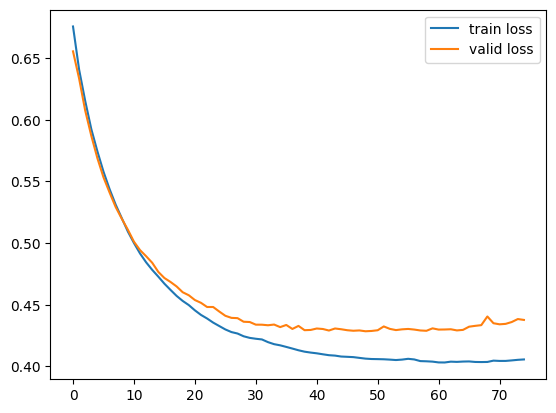

In [19]:
import copy
nb_epochs = 75

def train(model, nb_epochs, criterion, optimizer):
    """
    Function used to train a model, return the best model on the validation dataset.
    Print the learning graph.
    """
    train_losses, valid_losses = [], []
    best_model = model
    best_validation_loss = np.Inf
    optimizer.zero_grad()

    for epoch in tqdm(range(nb_epochs)):
        # training
        train_loss = 0.0
        train_batches = 0
        for xt, yt in train_gen():
            yt = yt.view(-1,1).float()
            predictions = model(xt)
            loss = criterion(predictions, yt)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_batches += 1
        train_losses.append(train_loss / train_batches)
        # validation
        valid_loss = 0.0
        valid_batches = 0
        with torch.no_grad():
            for xv, yv in valid_gen():
                yv = yv.view(-1,1).float()
                predictions = model(xv)
                loss = criterion(predictions, yv)
                valid_loss += loss.item()
                valid_batches += 1
                # save the best model based on the validation loss
            valloss = valid_loss / valid_batches
            valid_losses.append(valloss)

        if best_validation_loss < valloss:
            best_model = copy.deepcopy(model)
            best_validation_loss = valloss
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.legend()
    return best_model
best_model = train(model, 75, criterion, optimizer)

## Evaluation (3 point)

**\[1 point\] Compute the accuracy for the 3 splits (training, validation, test).**

In [20]:
# Your code
# Note that we need to use a sigmoid on the output now.
def evaluate(model, dataloader):
    """
    Function evaluating the model on dataset.
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader():
            targets = targets.view(-1,1).float()
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total
def accuracy(model):
    """
    Print the accuracy of the model for the 3 dataset (train, val, test) ordered
    """
    with torch.no_grad():
        train_accuracy = evaluate(model, train_gen)
        val_accuracy = evaluate(model, valid_gen)
        test_accuracy = evaluate(model, test_gen)
    print(train_accuracy, val_accuracy, test_accuracy)
accuracy(best_model)

0.8308 0.8244 0.82384


The accuracy for our model for the train, val and test dataset are: 0.8308 0.8244 0.82384

**\[1 point\] Code a `predict` function which take some text as input and returns a prediction class and score (the output of the sigmoid).**

In [21]:
def predict(
    text: str,
    text_pipeline: Callable[[str], torch.Tensor],
    model: nn.Module,
    device: str,
) -> Tuple[int, float]:
    """
    Return the predicted class and score for a given input.
    Args:
        text: a given review.
        text_pipeline: a function taking a text as input and returning a tensor (model's input).
        model: a pre-trained model.
        device: the device on which the computation occurs.
    Returns:
        A tuple (label, score).
    """
    data = text_pipeline(text)
    outputs = model(data)
    score = torch.sigmoid(outputs)
    predicted = torch.round(score)
    return predicted.item(), score.item()
    

In [22]:
text = "In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle."
predict(text, text_pipeline, best_model, device)

(0.0, 0.1244770959019661)

In [23]:
data['tuple']= data.text.apply(lambda x: predict(x, text_pipeline, best_model, device))
data[['pred', 'proba']] = data.tuple.apply(pd.Series)
data.drop('tuple', axis=1, inplace=True)
data

,text,label,pred,proba
0,After reading tons of good reviews about this ...,1,0.0,0.133568
1,To be fair they did as well as they could with...,0,0.0,0.008846
2,Really an amazing pile of pap! <br /><br />A p...,0,0.0,0.013403
3,I saw this film last night following a lot of ...,0,1.0,0.882597
4,One of the greatest film I have seen this year...,1,1.0,0.804854
...,...,...,...,...
19995,"New York, I Love You is a collective work of e...",1,1.0,0.975211
19996,The movie remains in the gray for far too long...,0,0.0,0.044384
19997,SPOILERS THROUGH: <br /><br />I really am in t...,1,1.0,0.727883
19998,Lets make a movie about a talk show that alrea...,0,0.0,0.355696


In [24]:
wrong = data.loc[data.label != data.pred]
wrong.reset_index(inplace=True)
wrong

,index,text,label,pred,proba
0,0,After reading tons of good reviews about this ...,1,0.0,0.133568
1,3,I saw this film last night following a lot of ...,0,1.0,0.882597
2,11,"As a gamer, I can't say I like this film. Fact...",0,1.0,0.576095
3,14,The first time i saw it i got half of it but i...,1,0.0,0.241436
4,27,"You know, I went to see ""The Hills have eyes 2...",0,1.0,0.640755
...,...,...,...,...,...
3379,19972,The dialogue was pretty dreadful. The plot not...,0,1.0,0.795700
3380,19975,This low-grade Universal chiller has just been...,0,1.0,0.674633
3381,19976,I made a special effort to see this movie and ...,0,1.0,0.557625
3382,19977,Lot of silly plot holes in the film. First we ...,0,1.0,0.769175


**\[1 point\] For two wrongly classified samples, try guessing why the model was wrong.**


In [28]:
wrong.iloc[3].text

"The first time i saw it i got half of it but i watched and i knew later on it was about a salem witch trials. They focused on the Sara Good's family. SHE is famous for cursing a priest which came true. In the film it depicts her daughter dorcas and her husband the spirit of Ann Putnam Sara's husband comes to the future hunts this girl to redeem her soul. which does happen at the end of the movie. Dorcas is depict as witch at 5years old who is burned at the stake. Which never happen Ann putnam saves her from the flames. the girl is safe she goes to Ann putnam's grave to to see that is not empty but it is at first because she accuse her of witchcraft, and lets her burn to death. Now that ann putnam saves her her spirit is redeemed, and she is not a outcast to society for the salem witch trials."

The first wrong classified is because the viewer didn't give it's opinion but just describe what's happening in the movie

In [34]:
wrong.iloc[8].text, wrong.iloc[8].proba

("This was one of the funniest and greatest sitcom to hit national television. Its unfortunate that the show is not placed amongst great sitcoms where it truly belongs. The actors did a superb job and seasons one thru six were the show at its peak point. Although season seven was not as great when compared to the previous six, it was still funny. Season 8 was the real problem kicked in. Without Topher grace or Ashton Kutcher the show simply fell apart. Not too say, the other actors weren't great if any of 2 main characters had left such as Danny Masterson, Wilder Valderamma Kurtwood Smith, Debra Jo Rupp, Mila Kunis and Laura Prepon ( Don Starks and tommy Chong are great too) left the show it would have the same affect. And the inclusion of Randy ( Josh Meyers) didn't help either because he was not well received by the shows fans. I believe if the show ended a year ago it would have certainly gone down in history as one of the sitcom greats. Season 8 was a little dull but the finale was

The second one is missclassified because he explain why the last seasson is bad, but overall he liked the show really much, and he doesn't spend muchh time explaining it, we can see that the model  is really not sure, giving a proba of **0.47**, really close to 0.5

## Bonus

Modify the classifier. Instead of using a simple logistic regression, create a multilayer perceptron. Something like `input -> linear(embedding_size, 128) -> activation function -> linear(128, nb_classes) -> output`, for a two layer perceptron.

For the activation function, you can use [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) or [another non-linear activation function](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) of your choice.

Train your new classifier, look at the loss, and compare its accuracy with the logistic regression. Keep the model with the best validation loss.

In [ ]:
class AdvancedClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        super().__init__()
        self.linear1 = nn.Linear(embedding_size, 128)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(128, nb_classes)


    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        # your code
        x = self.linear1(input)
        x = self.activation(x)
        output = self.linear2(x)
        return output

100%|██████████| 200/200 [04:32<00:00,  1.36s/it]


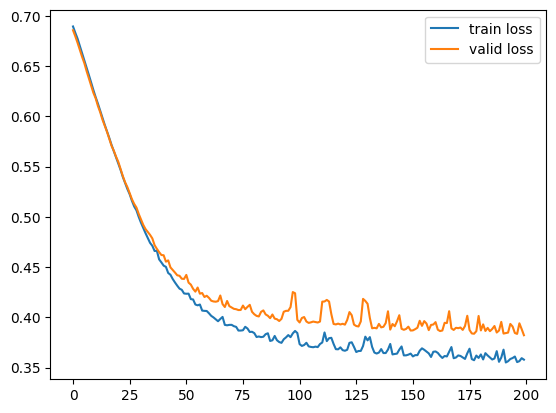

In [ ]:
model = AdvancedClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005, weight_decay=0.00005)
advanced_model = train(model, 200, criterion, optimizer)

In [ ]:
accuracy(advanced_model)

0.84695 0.8372 0.8366
